In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/materiai2023/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/materiai2023


In [ ]:
!pip install pymatgen
!pip install mp_api

In [ ]:
import os
import glob
import numpy as np
from mp_api.client import MPRester
from pymatgen.io.cif import CifParser
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import matplotlib.pyplot as plt

No module named 'phonopy'
No module named 'phonopy'


In [ ]:
MY_API_KEY = ""

# define physical properties/infos you want to obtain
# properties = ['nsites', 'formula_pretty','material_id','structure']
# is_stable=True
# is_metal=False
# with MPRester( MY_API_KEY ) as mpr:
#     results = mpr.materials.summary.search(num_sites=[1, 4], is_stable=is_stable, fields=properties)

#Output
# path_output_dir = "./CIFs/"
# os.makedirs(path_output_dir)
# for mat in results:
#     ofile = path_output_dir+mat.material_id+"_"+mat.formula_pretty+".cif"
#     mat.structure.to(filename = ofile)

No module named 'phonopy'
No module named 'phonopy'


Retrieving SummaryDoc documents:   0%|          | 0/4214 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pymatgen/core/periodic_table.py:138: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymatgen/core/periodic_table.py:138: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymatgen/core/periodic_table.py:138: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


In [ ]:
# CIFファイルのパス
cif_files = glob.glob("./CIFs/*.cif")

combined_vectors = []
element_vectors = []
atomic_positions_arrays = []
volumes = []

max_atomic_number = 86
for cif_file in cif_files:
    # CIFファイルを解析
    parser = CifParser(cif_file)
    structure = parser.parse_structures()[0]  # 最初の構造を取得

    # 元素の一覧を取得
    element_list = [site.species_string for site in structure.sites]

    atomic_numbers = [site.specie.Z for site in structure.sites]
    if any(atomic_number > max_atomic_number for atomic_number in atomic_numbers):
        continue
    element_vector = np.zeros(max_atomic_number + 1)
    for atomic_number in atomic_numbers:
        element_vector[atomic_number] += 1
    if len(atomic_numbers) < 4:
        element_vector[0] += 4 - len(atomic_numbers)

    atomic_positions = []
    N_empty = 4 - len(atomic_numbers)
    for _ in range(N_empty):
        atomic_positions.extend([0., 0., 0.])
    for site in sorted(structure.sites, key=lambda x: x.specie.Z):
        atomic_positions.extend(site.frac_coords)

    atomic_positions_array = np.array(atomic_positions)

    element_vectors.append(element_vector)
    atomic_positions_arrays.append(atomic_positions_array)
    combined_vector = np.concatenate((element_vector, atomic_positions_array))
    combined_vectors.append(combined_vector)
    volumes.append(structure.volume)

/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1191: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1224: UserWarning: Issues encountered while parsing CIF: 3 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1224: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1224: UserWarning: Issu

In [46]:
indices = np.array(range(len(volumes)))

## Only Atomic Type

In [49]:
X_train_atomtype, X_test_atomtype, y_train_atomtype, y_test_atomtype, indices_train_atomtype, indices_test_atomtype = train_test_split(np.array(element_vectors), np.array(volumes), indices, test_size=0.2, random_state=42)

# モデルの定義
model_atomtype = Sequential()
model_atomtype.add(Dense(64, input_dim=X_train_atomtype.shape[1], activation='relu'))  # 入力層
model_atomtype.add(Dropout(0.1))
model_atomtype.add(Dense(32, activation='relu'))  # 隠れ層
model_atomtype.add(Dense(1, activation='linear'))  # 出力層

# モデルのコンパイル
model_atomtype.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# モデルのトレーニング
model_atomtype.fit(X_train_atomtype, y_train_atomtype, epochs=300, batch_size=32, validation_split=0.2)

# モデルの評価
mse = model_atomtype.evaluate(X_test_atomtype, y_test_atomtype)
print("Mean Squared Error:", mse)

Epoch 1/300
77/77 [==============================] - 1s 5ms/step - loss: 5574.8945 - mse: 5574.8945 - val_loss: 4784.8379 - val_mse: 4784.8379
Epoch 2/300
77/77 [==============================] - 0s 3ms/step - loss: 2522.6257 - mse: 2522.6257 - val_loss: 922.4437 - val_mse: 922.4437
Epoch 3/300
77/77 [==============================] - 0s 3ms/step - loss: 510.5079 - mse: 510.5079 - val_loss: 404.8313 - val_mse: 404.8313
Epoch 4/300
77/77 [==============================] - 0s 3ms/step - loss: 230.8416 - mse: 230.8416 - val_loss: 224.4630 - val_mse: 224.4630
Epoch 5/300
77/77 [==============================] - 0s 3ms/step - loss: 133.6165 - mse: 133.6165 - val_loss: 139.9107 - val_mse: 139.9107
Epoch 6/300
77/77 [==============================] - 0s 3ms/step - loss: 93.9318 - mse: 93.9318 - val_loss: 91.5811 - val_mse: 91.5811
Epoch 7/300
77/77 [==============================] - 0s 3ms/step - loss: 69.2085 - mse: 69.2085 - val_loss: 64.7664 - val_mse: 64.7664
Epoch 8/300
77/77 [==========

In [50]:
prediction = model_atomtype.predict(np.array(element_vectors)[0].reshape(1, -1))
print("予測値：", prediction)

# CIFファイルのパス
cif_file_path = "./CIFs/mp-1000_BaTe.cif"

# CIFファイルを解析
parser = CifParser(cif_file_path)
structure = parser.parse_structures()[0]  # 最初の構造を取得
print(structure.volume)

1/1 [==============================] - 0s 59ms/step
予測値： [[68.55469]]
89.09415778463824


/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1191: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(


25/25 [==============================] - 0s 2ms/step


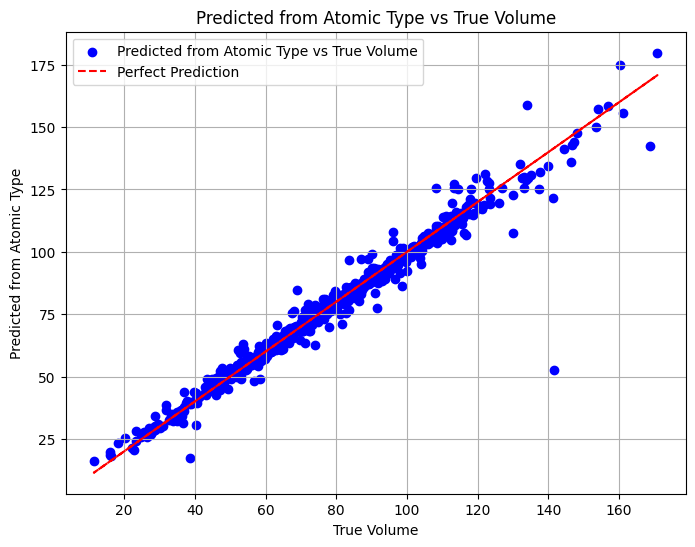

In [51]:
# 真の体積と予測された体積のデータを取得
true_volumes_atomtype = y_test_atomtype  # 真の体積
predicted_volumes_atomtype = model_atomtype.predict(X_test_atomtype)  # 予測された体積

# プロットの作成
plt.figure(figsize=(8, 6))
plt.scatter(true_volumes_atomtype, predicted_volumes_atomtype, color='blue', label='Predicted from Atomic Type vs True Volume')

# 軸ラベルとタイトルの追加
plt.xlabel('True Volume')
plt.ylabel('Predicted from Atomic Type')
plt.title('Predicted from Atomic Type vs True Volume')

# 対角線を追加（真の体積と予測された体積が一致する場合）
plt.plot(true_volumes_atomtype, true_volumes_atomtype, color='red', linestyle='--', label='Perfect Prediction')

# 凡例の表示
plt.legend()

# グリッドの表示
plt.grid(True)

# グラフの表示
plt.show()

25/25 [==============================] - 0s 1ms/step


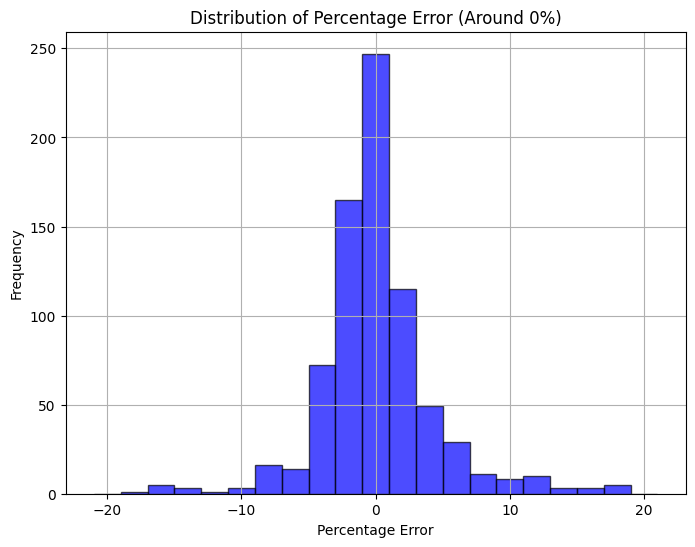

In [52]:
# 真の体積と予測された体積のデータを取得
true_volumes_atomtype = y_test_atomtype  # 真の体積
predicted_volumes_atomtype = model_atomtype.predict(X_test_atomtype)[:,0]  # 予測された体積

# 誤差の割合を計算
errors = ((predicted_volumes_atomtype - true_volumes_atomtype) / true_volumes_atomtype) * 100

# ビンの範囲を計算
bin_width = 2  # ビンの幅（2%）
half_bin_width = bin_width / 2  # ビンの幅の半分
bin_edges = np.arange(-20 - half_bin_width, 21 + half_bin_width, bin_width)  # ビンの境界を計算する際にビンの幅の半分を考慮

# プロットの作成
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7)

# 軸ラベルとタイトルの追加
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Error (Around 0%)')

# グリッドの表示
plt.grid(True)

# グラフの表示
plt.show()

In [67]:
# 誤差の割合を計算
errors = ((predicted_volumes_atomtype - true_volumes_atomtype) / true_volumes_atomtype) * 100

# 誤差が20%以上のデータのインデックスを取得
indices_above_20_percent_atomtype = sorted(indices_test_atomtype[np.where(np.abs(errors) >= 20)[0]])

# 結果の表示
print("誤差が20%以上のデータのインデックス:", indices_above_20_percent_atomtype)

誤差が20%以上のデータのインデックス: [120, 1070, 1084, 1094, 1350, 1918, 2166, 2753, 3088, 3789]


In [68]:
for cif in np.array(cif_files)[indices_above_20_percent_atomtype]:
    print(cif_file)
    # CIFファイルを解析
    parser = CifParser(cif_file)
    structure = parser.parse_structures()[0]  # 最初の構造を取得
    # 構造情報を表示

    print("格子パラメータ:")
    print("a =", structure.lattice.a, "Å")
    print("b =", structure.lattice.b, "Å")
    print("c =", structure.lattice.c, "Å")
    print("α =", structure.lattice.alpha, "°")
    print("β =", structure.lattice.beta, "°")
    print("γ =", structure.lattice.gamma, "°")
    print("元素と座標:")
    for site in structure.sites:
        print(site.species_string, site.frac_coords)

./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90

/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1191: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(


## Only Fractional Coordinate

In [56]:
X_train_fraccrd, X_test_fraccrd, y_train_fraccrd, y_test_fraccrd, indices_train_fraccrd, indices_test_fraccrd = train_test_split(np.array(atomic_positions_arrays), np.array(volumes), indices, test_size=0.2, random_state=42)

# モデルの定義
model_fraccrd = Sequential()
model_fraccrd.add(Dense(64, input_dim=X_train_fraccrd.shape[1], activation='relu'))  # 入力層
model_fraccrd.add(Dropout(0.1))
model_fraccrd.add(Dense(32, activation='relu'))  # 隠れ層
model_fraccrd.add(Dense(1, activation='linear'))  # 出力層

# モデルのコンパイル
model_fraccrd.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# モデルのトレーニング
model_fraccrd.fit(X_train_fraccrd, y_train_fraccrd, epochs=300, batch_size=32, validation_split=0.2)

# モデルの評価
mse = model_fraccrd.evaluate(X_test_fraccrd, y_test_fraccrd)
print("Mean Squared Error:", mse)

Epoch 1/300
77/77 [==============================] - 1s 5ms/step - loss: 5539.7568 - mse: 5539.7568 - val_loss: 4517.6226 - val_mse: 4517.6226
Epoch 2/300
77/77 [==============================] - 0s 3ms/step - loss: 2211.9478 - mse: 2211.9478 - val_loss: 698.5804 - val_mse: 698.5804
Epoch 3/300
77/77 [==============================] - 0s 3ms/step - loss: 714.5446 - mse: 714.5446 - val_loss: 669.6334 - val_mse: 669.6334
Epoch 4/300
77/77 [==============================] - 0s 3ms/step - loss: 694.1459 - mse: 694.1459 - val_loss: 660.0659 - val_mse: 660.0659
Epoch 5/300
77/77 [==============================] - 0s 2ms/step - loss: 686.4962 - mse: 686.4962 - val_loss: 655.6266 - val_mse: 655.6266
Epoch 6/300
77/77 [==============================] - 0s 3ms/step - loss: 679.1377 - mse: 679.1377 - val_loss: 649.7714 - val_mse: 649.7714
Epoch 7/300
77/77 [==============================] - 0s 3ms/step - loss: 671.7359 - mse: 671.7359 - val_loss: 643.7651 - val_mse: 643.7651
Epoch 8/300
77/77 [==

In [57]:
prediction = model_fraccrd.predict(np.array(atomic_positions_arrays)[0].reshape(1, -1))
print("予測値：", prediction)

# CIFファイルのパス
cif_file_path = "./CIFs/mp-1000_BaTe.cif"

# CIFファイルを解析
parser = CifParser(cif_file_path)
structure = parser.parse_structures()[0]  # 最初の構造を取得
print(structure.volume)

1/1 [==============================] - 0s 88ms/step
予測値： [[78.80933]]
89.09415778463824


25/25 [==============================] - 0s 2ms/step


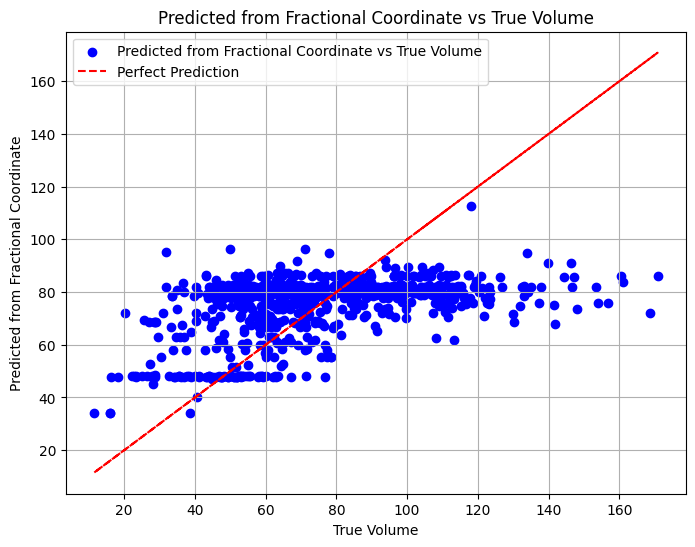

In [59]:
# 真の体積と予測された体積のデータを取得
true_volumes_fraccrd = y_test_fraccrd  # 真の体積
predicted_volumes_fraccrd = model_fraccrd.predict(X_test_fraccrd)  # 予測された体積

# プロットの作成
plt.figure(figsize=(8, 6))
plt.scatter(true_volumes_fraccrd, predicted_volumes_fraccrd, color='blue', label='Predicted from Fractional Coordinate vs True Volume')

# 軸ラベルとタイトルの追加
plt.xlabel('True Volume')
plt.ylabel('Predicted from Fractional Coordinate')
plt.title('Predicted from Fractional Coordinate vs True Volume')

# 対角線を追加（真の体積と予測された体積が一致する場合）
plt.plot(true_volumes_fraccrd, true_volumes_fraccrd, color='red', linestyle='--', label='Perfect Prediction')

# 凡例の表示
plt.legend()

# グリッドの表示
plt.grid(True)

# グラフの表示
plt.show()

25/25 [==============================] - 0s 1ms/step


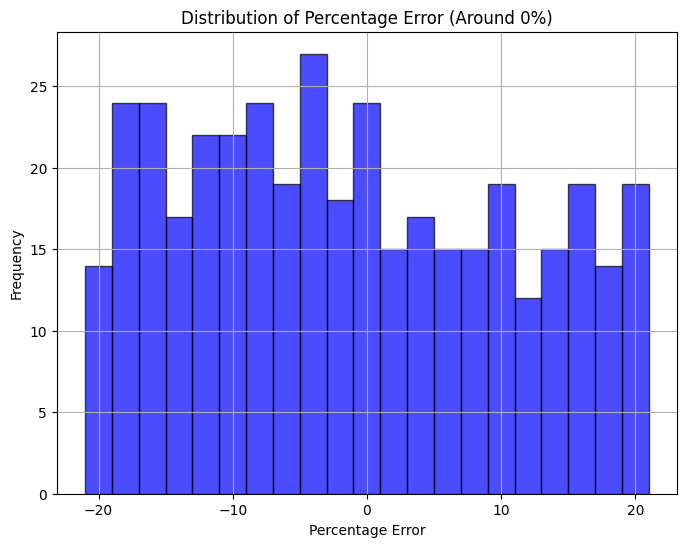

In [60]:
# 真の体積と予測された体積のデータを取得
true_volumes_fraccrd = y_test_fraccrd  # 真の体積
predicted_volumes_fraccrd = model_fraccrd.predict(X_test_fraccrd)[:,0]  # 予測された体積

# 誤差の割合を計算
errors = ((predicted_volumes_fraccrd - true_volumes_fraccrd) / true_volumes_fraccrd) * 100

# ビンの範囲を計算
bin_width = 2  # ビンの幅（2%）
half_bin_width = bin_width / 2  # ビンの幅の半分
bin_edges = np.arange(-20 - half_bin_width, 21 + half_bin_width, bin_width)  # ビンの境界を計算する際にビンの幅の半分を考慮

# プロットの作成
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7)

# 軸ラベルとタイトルの追加
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Error (Around 0%)')

# グリッドの表示
plt.grid(True)

# グラフの表示
plt.show()

## Both Atomic type and Fractional Coordinate

In [61]:
X_train_atomtype_fraccrd, X_test_atomtype_fraccrd, y_train_atomtype_fraccrd, y_test_atomtype_fraccrd, indices_train_atomtype_fraccrd, indices_test_atomtype_fraccrd = train_test_split(np.array(combined_vectors), np.array(volumes), indices, test_size=0.2, random_state=42)

# モデルの定義
model_atomtype_fraccrd = Sequential()
model_atomtype_fraccrd.add(Dense(64, input_dim=X_train_atomtype_fraccrd.shape[1], activation='relu'))  # 入力層
model_atomtype_fraccrd.add(Dropout(0.1))
model_atomtype_fraccrd.add(Dense(32, activation='relu'))  # 隠れ層
model_atomtype_fraccrd.add(Dense(1, activation='linear'))  # 出力層

# モデルのコンパイル
model_atomtype_fraccrd.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# モデルのトレーニング
model_atomtype_fraccrd.fit(X_train_atomtype_fraccrd, y_train_atomtype_fraccrd, epochs=300, batch_size=32, validation_split=0.2)

# モデルの評価
mse = model_atomtype_fraccrd.evaluate(X_test_atomtype_fraccrd, y_test_atomtype_fraccrd)
print("Mean Squared Error:", mse)

Epoch 1/300
77/77 [==============================] - 1s 5ms/step - loss: 5405.6021 - mse: 5405.6021 - val_loss: 3965.2341 - val_mse: 3965.2341
Epoch 2/300
77/77 [==============================] - 0s 2ms/step - loss: 1509.6365 - mse: 1509.6365 - val_loss: 532.1045 - val_mse: 532.1045
Epoch 3/300
77/77 [==============================] - 0s 3ms/step - loss: 411.9633 - mse: 411.9633 - val_loss: 328.3221 - val_mse: 328.3221
Epoch 4/300
77/77 [==============================] - 0s 3ms/step - loss: 253.4543 - mse: 253.4543 - val_loss: 213.5102 - val_mse: 213.5102
Epoch 5/300
77/77 [==============================] - 0s 3ms/step - loss: 176.7688 - mse: 176.7688 - val_loss: 149.4740 - val_mse: 149.4740
Epoch 6/300
77/77 [==============================] - 0s 3ms/step - loss: 134.4797 - mse: 134.4797 - val_loss: 114.9993 - val_mse: 114.9993
Epoch 7/300
77/77 [==============================] - 0s 3ms/step - loss: 110.5367 - mse: 110.5367 - val_loss: 91.2124 - val_mse: 91.2124
Epoch 8/300
77/77 [====

In [62]:
prediction = model_atomtype_fraccrd.predict(np.array(combined_vectors)[0].reshape(1, -1))
print("予測値：", prediction)

# CIFファイルのパス
cif_file_path = "./CIFs/mp-1000_BaTe.cif"

# CIFファイルを解析
parser = CifParser(cif_file_path)
structure = parser.parse_structures()[0]  # 最初の構造を取得
print(structure.volume)

1/1 [==============================] - 0s 57ms/step
予測値： [[67.48136]]
89.09415778463824


25/25 [==============================] - 0s 1ms/step


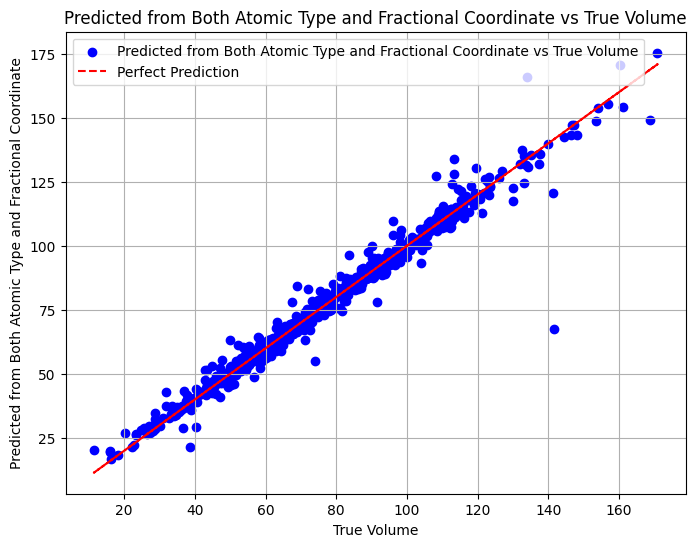

In [63]:
# 真の体積と予測された体積のデータを取得
true_volumes_atomtype_fraccrd = y_test_atomtype_fraccrd  # 真の体積
predicted_volumes_atomtype_fraccrd = model_atomtype_fraccrd.predict(X_test_atomtype_fraccrd)  # 予測された体積

# プロットの作成
plt.figure(figsize=(8, 6))
plt.scatter(true_volumes_atomtype_fraccrd, predicted_volumes_atomtype_fraccrd, color='blue', label='Predicted from Both Atomic Type and Fractional Coordinate vs True Volume')

# 軸ラベルとタイトルの追加
plt.xlabel('True Volume')
plt.ylabel('Predicted from Both Atomic Type and Fractional Coordinate')
plt.title('Predicted from Both Atomic Type and Fractional Coordinate vs True Volume')

# 対角線を追加（真の体積と予測された体積が一致する場合）
plt.plot(true_volumes_atomtype_fraccrd, true_volumes_atomtype_fraccrd, color='red', linestyle='--', label='Perfect Prediction')

# 凡例の表示
plt.legend()

# グリッドの表示
plt.grid(True)

# グラフの表示
plt.show()

25/25 [==============================] - 0s 1ms/step


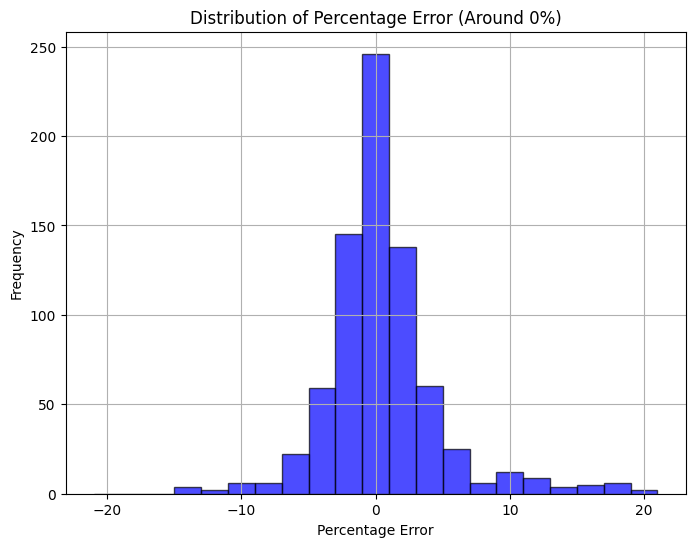

In [64]:
# 真の体積と予測された体積のデータを取得
true_volumes_atomtype_fraccrd = y_test_atomtype_fraccrd  # 真の体積
predicted_volumes_atomtype_fraccrd = model_atomtype_fraccrd.predict(X_test_atomtype_fraccrd)[:,0]  # 予測された体積

# 誤差の割合を計算
errors = ((predicted_volumes_atomtype_fraccrd - true_volumes_atomtype_fraccrd) / true_volumes_atomtype_fraccrd) * 100

# ビンの範囲を計算
bin_width = 2  # ビンの幅（2%）
half_bin_width = bin_width / 2  # ビンの幅の半分
bin_edges = np.arange(-20 - half_bin_width, 21 + half_bin_width, bin_width)  # ビンの境界を計算する際にビンの幅の半分を考慮

# プロットの作成
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7)

# 軸ラベルとタイトルの追加
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Error (Around 0%)')

# グリッドの表示
plt.grid(True)

# グラフの表示
plt.show()

In [69]:
# 誤差の割合を計算
errors = ((predicted_volumes_atomtype_fraccrd - true_volumes_atomtype_fraccrd) / true_volumes_atomtype_fraccrd) * 100

# 誤差が20%以上のデータのインデックスを取得
indices_above_20_percent_atomtype_fraccrd = sorted(indices_test_atomtype_fraccrd[np.where(np.abs(errors) >= 20)[0]])

# 結果の表示
print("誤差が20%以上のデータのインデックス:", indices_above_20_percent_atomtype_fraccrd)

誤差が20%以上のデータのインデックス: [120, 599, 864, 1070, 1094, 1097, 1104, 1362, 1918, 1966, 2752, 2753, 3088, 3789, 3795]


In [70]:
for cif in np.array(cif_files)[indices_above_20_percent_atomtype_fraccrd]:
    print(cif_file)
    # CIFファイルを解析
    parser = CifParser(cif_file)
    structure = parser.parse_structures()[0]  # 最初の構造を取得
    # 構造情報を表示

    print("格子パラメータ:")
    print("a =", structure.lattice.a, "Å")
    print("b =", structure.lattice.b, "Å")
    print("c =", structure.lattice.c, "Å")
    print("α =", structure.lattice.alpha, "°")
    print("β =", structure.lattice.beta, "°")
    print("γ =", structure.lattice.gamma, "°")
    print("元素と座標:")
    for site in structure.sites:
        print(site.species_string, site.frac_coords)

./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90

/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1191: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(


格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]


## Failed data for both `Atomic type & Fractional Corrdinate` and `Atomic Type`

In [72]:
for cif in np.array(cif_files)[np.intersect1d(indices_above_20_percent_atomtype_fraccrd, indices_above_20_percent_atomtype)]:
    print(cif_file)
    # CIFファイルを解析
    parser = CifParser(cif_file)
    structure = parser.parse_structures()[0]  # 最初の構造を取得
    # 構造情報を表示

    print("格子パラメータ:")
    print("a =", structure.lattice.a, "Å")
    print("b =", structure.lattice.b, "Å")
    print("c =", structure.lattice.c, "Å")
    print("α =", structure.lattice.alpha, "°")
    print("β =", structure.lattice.beta, "°")
    print("γ =", structure.lattice.gamma, "°")
    print("元素と座標:")
    for site in structure.sites:
        print(site.species_string, site.frac_coords)

./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90.0 °
元素と座標:
Ba [0.75       0.13302927 0.26605655]
Ba [0.25       0.86697073 0.73394345]
Pb [0.75       0.42297273 0.84594346]
Pb [0.25       0.57702727 0.15405654]
./CIFs/mp-20136_BaPb.cif
格子パラメータ:
a = 4.89468292 Å
b = 5.38796719 Å
c = 6.93845608 Å
α = 112.84679213999999 °
β = 90.0 °
γ = 90